### **LABORATORIO 6**

#### Autores: 
- Diego Lemus
- Fabián Juárez

#### Fecha:
- 23 de Septiembre 2024

#### Repositorio:
- Link: https://github.com/TheDeloz-v2/MS-LAB6


### LIBRERIAS

In [11]:
#%pip install simpy
#%pip install matplotlib

import simpy
import random
import statistics
import matplotlib.pyplot as plt

### PARAMETROS GENERALES

In [12]:
random.seed(42)     # Semilla para reproducibilidad
TOTAL_TIME = 3600   # Tiempo total de simulacion en segundos (1 hora)

### DEFINCION DE SIMULACION

In [13]:

def request_generator(env, arrival_rate, server, stats, max_requests_per_minute):
    """
    Genera solicitudes de manera exponencial y las envia al servidor.
    
    Args:
        env: entorno de simulacion de SimPy
        arrival_rate: tasa de llegada de solicitudes (solicitudes por segundo)
        server: recurso de servidor de SimPy
        stats: diccionario para almacenar estadisticas
        max_requests_per_minute: numero maximo de solicitudes por minuto
        
    Yields:
        eventos de tiempo de espera para cada solicitud
    """
    request_id = 0
    minute = 0
    while env.now < TOTAL_TIME:
        # Calcular el tiempo al inicio del siguiente minuto
        next_minute = (minute + 1) * 60
        arrivals_this_minute = 0
        while env.now < next_minute and arrivals_this_minute < max_requests_per_minute:
            interarrival_time = random.expovariate(arrival_rate)
            yield env.timeout(interarrival_time)
            if env.now > TOTAL_TIME:
                break
            env.process(handle_request(env, request_id, server, stats))
            request_id += 1
            arrivals_this_minute += 1
        minute += 1

def handle_request(env, request_id, server, stats):
    """
    Procesa cada solicitud, incluyendo tiempos de espera y servicio.
    
    Args:
        env: entorno de simulacion de SimPy
        request_id: identificador de solicitud
        server: recurso de servidor de SimPy
        stats: diccionario para almacenar estadisticas
        
    Yields:
        eventos de tiempo de espera para cada solicitud
    """
    arrival_time = env.now
    with server.request() as req:
        queue_entry_time = env.now
        # Solicitar acceso al servidor (puede causar espera en cola)
        yield req
        queue_exit_time = env.now
        queue_time = queue_exit_time - queue_entry_time
        # Registrar tiempo en cola
        stats['queue_times'].append(queue_time)
        # Tiempo de servicio
        service_time = random.expovariate(server.service_rate)
        # Registrar tiempos
        stats['service_times'].append(service_time)
        # Actualizar estadisticas del servidor
        server.stats['requests_handled'] += 1
        server.stats['busy_times'].append(service_time)
        yield env.timeout(service_time)
        departure_time = env.now
        # Registrar tiempo de salida
        stats['departure_times'].append(departure_time)

def simulate_system(system_name, num_servers, service_rate, arrival_rate, max_requests_per_minute):
    """
    Simula un sistema dado y recopila estadisticas.
    
    Args:
        system_name: nombre del sistema
        num_servers: numero de servidores
        service_rate: tasa de servicio por servidor
        arrival_rate: tasa de llegada de solicitudes
        max_requests_per_minute: numero maximo de solicitudes por minuto
        
    Returns:
        diccionario con estadisticas del sistema
    """
    env = simpy.Environment()
    stats = {
        'queue_times': [],
        'service_times': [],
        'departure_times': []
    }
    # Crear recurso de servidores
    server = simpy.Resource(env, capacity=num_servers)
    server.service_rate = service_rate  # Tasa de servicio por servidor
    # Agregar estadisticas al servidor
    server.stats = {
        'requests_handled': 0,
        'busy_times': []
    }
    # Iniciar el generador de solicitudes
    env.process(request_generator(env, arrival_rate, server, stats, max_requests_per_minute))
    # Ejecutar la simulacion
    env.run(until=TOTAL_TIME)
    # Calcular estadisticas adicionales
    total_busy_time = sum(server.stats['busy_times'])
    total_idle_time = (TOTAL_TIME * num_servers) - total_busy_time
    average_queue_time = statistics.mean(stats['queue_times']) if stats['queue_times'] else 0
    average_queue_length = sum(stats['queue_times']) / TOTAL_TIME
    last_departure_time = max(stats['departure_times']) if stats['departure_times'] else 0
    # Preparar resultados
    results = {
        'system_name': system_name,
        'num_servers': num_servers,
        'total_requests': server.stats['requests_handled'],
        'total_busy_time': total_busy_time,
        'total_idle_time': total_idle_time,
        'total_queue_time': sum(stats['queue_times']),
        'average_queue_time': average_queue_time,
        'average_queue_length': average_queue_length,
        'last_departure_time': last_departure_time,
        'queue_times': stats['queue_times'],
    }
    return results

def print_results(results):
    """
    Imprime los resultados de la simulacion para un sistema.
    
    Args:
        results: diccionario con estadisticas del sistema
    """
    print(f"\nResultados de {results['system_name']}:")
    print(f"a. Solicitudes Totales Atendidas: {results['total_requests']}")
    print(f"b. Tiempo Ocupado Total de Servidores: {results['total_busy_time']:.2f} segundos")
    print(f"c. Tiempo Desocupado Total de Servidores: {results['total_idle_time']:.2f} segundos")
    print(f"d. Tiempo Total en Cola: {results['total_queue_time']:.2f} segundos")
    print(f"e. Tiempo Promedio en Cola por Solicitud: {results['average_queue_time']:.4f} segundos")
    print(f"f. Longitud Promedio de Cola por Segundo: {results['average_queue_length']:.4f}")
    print(f"g. Tiempo de Salida de la Última Solicitud: {results['last_departure_time']:.2f} segundos")


In [17]:
def plot_simulation_results(results):
    """
    Grafica los valores importantes de los resultados.

    Args:
        results: diccionario con estadisticas del sistema
    """
    # Grafico de tiempos en cola
    plt.figure(figsize=(10, 6))
    plt.plot(results['queue_times'], label="Tiempos en Cola")
    plt.title('Evolución del Tiempo en Cola')
    plt.xlabel('Número de Solicitud')
    plt.ylabel('Tiempo en Cola (segundos)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Histograma de tiempos en cola
    plt.figure(figsize=(10, 6))
    plt.hist(results['queue_times'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Histograma de Tiempos en Cola')
    plt.xlabel('Tiempo en Cola (segundos)')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

### INCISO 1


Resultados de Mountain Mega Computing:
a. Solicitudes Totales Atendidas: 144016
b. Tiempo Ocupado Total de Servidores: 1436.07 segundos
c. Tiempo Desocupado Total de Servidores: 2163.93 segundos
d. Tiempo Total en Cola: 944.85 segundos
e. Tiempo Promedio en Cola por Solicitud: 0.0066 segundos
f. Longitud Promedio de Cola por Segundo: 0.2625
g. Tiempo de Salida de la Última Solicitud: 3599.98 segundos


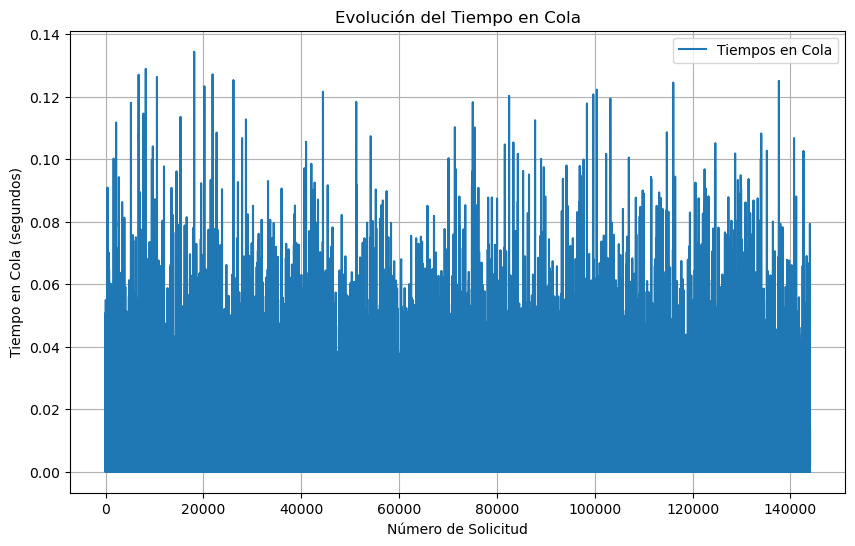

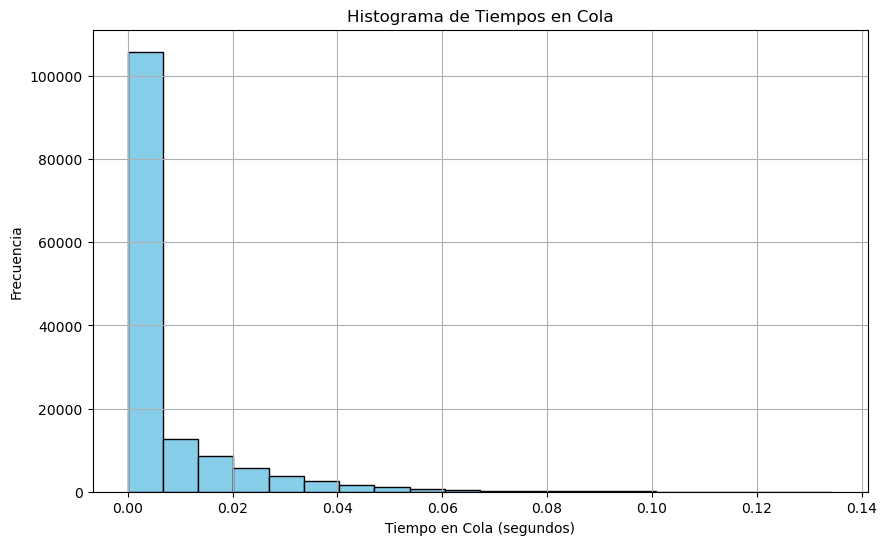


Resultados de Pizzita Computing:
a. Solicitudes Totales Atendidas: 144457
b. Tiempo Ocupado Total de Servidores: 14451.61 segundos
c. Tiempo Desocupado Total de Servidores: 21548.39 segundos
d. Tiempo Total en Cola: 19.86 segundos
e. Tiempo Promedio en Cola por Solicitud: 0.0001 segundos
f. Longitud Promedio de Cola por Segundo: 0.0055
g. Tiempo de Salida de la Última Solicitud: 3599.96 segundos


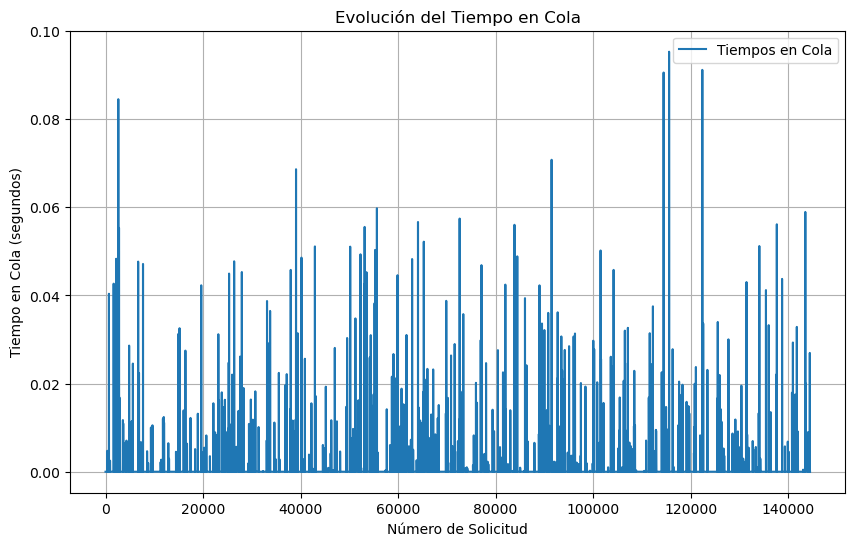

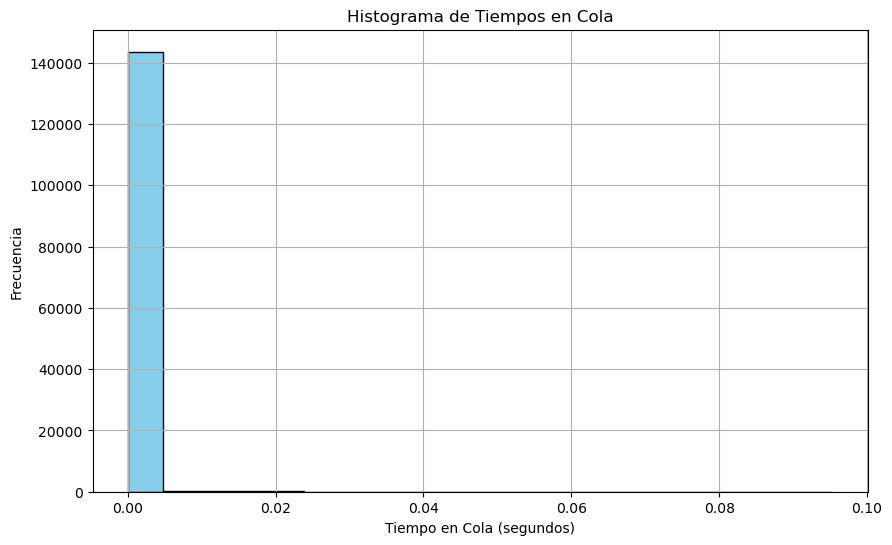

In [21]:
# Inciso 1: Simulacion inicial (2,400 solicitudes por minuto)
arrival_rate = 40
max_requests_per_minute = 2400

# Mountain Mega Computing
results_mountain = simulate_system(
    system_name='Mountain Mega Computing',
    num_servers=1,
    service_rate=100,
    arrival_rate=arrival_rate,
    max_requests_per_minute=max_requests_per_minute
)

# Pizzita Computing con 10 servidores
results_pizzita = simulate_system(
    system_name='Pizzita Computing',
    num_servers=10,
    service_rate=10,
    arrival_rate=arrival_rate,
    max_requests_per_minute=max_requests_per_minute
)

print_results(results_mountain)
plot_simulation_results(results_mountain)
print_results(results_pizzita)
plot_simulation_results(results_pizzita)

### INCISO 2

In [22]:
# Inciso 2: Determinar empiricamente el numero de servidores necesarios en Pizzita Computing
def find_required_servers(arrival_rate, max_requests_per_minute):
    """
    Encuentra el numero de servidores necesarios para que no haya espera en Pizzita Computing.
    
    Args:
        arrival_rate: tasa de llegada de solicitudes
        max_requests_per_minute: numero maximo de solicitudes por minuto
        
    Returns:
        numero de servidores necesarios
    """
    num_servers = 1
    while True:
        results = simulate_system(
            system_name='Pizzita Computing',
            num_servers=num_servers,
            service_rate=10,
            arrival_rate=arrival_rate,
            max_requests_per_minute=max_requests_per_minute
        )
        # Verificar si no hubo tiempos de espera en cola
        if all(q_time == 0 for q_time in results['queue_times']):
            print(f"\nNumero de servidores necesarios para que no haya espera: {num_servers}")
            break
        else:
            num_servers += 1
            # Limite maximo para evitar bucles infinitos
            if num_servers > 100:
                print("No se encontro un numero adecuado de servidores dentro del limite establecido.")
                break
    return num_servers

required_servers = find_required_servers(arrival_rate, max_requests_per_minute)


Numero de servidores necesarios para que no haya espera: 15


### INCISO 3


Resultados de Mountain Mega Computing (6,000 solicitudes por minuto):
a. Solicitudes Totales Atendidas: 359919
b. Tiempo Ocupado Total de Servidores: 3599.25 segundos
c. Tiempo Desocupado Total de Servidores: 0.75 segundos
d. Tiempo Total en Cola: 4814045.48 segundos
e. Tiempo Promedio en Cola por Solicitud: 13.3754 segundos
f. Longitud Promedio de Cola por Segundo: 1337.2349
g. Tiempo de Salida de la Última Solicitud: 3600.00 segundos


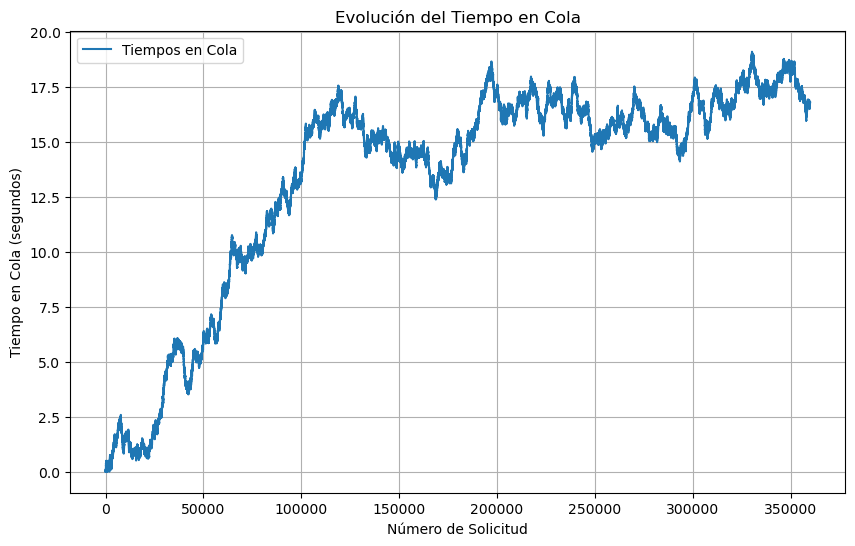

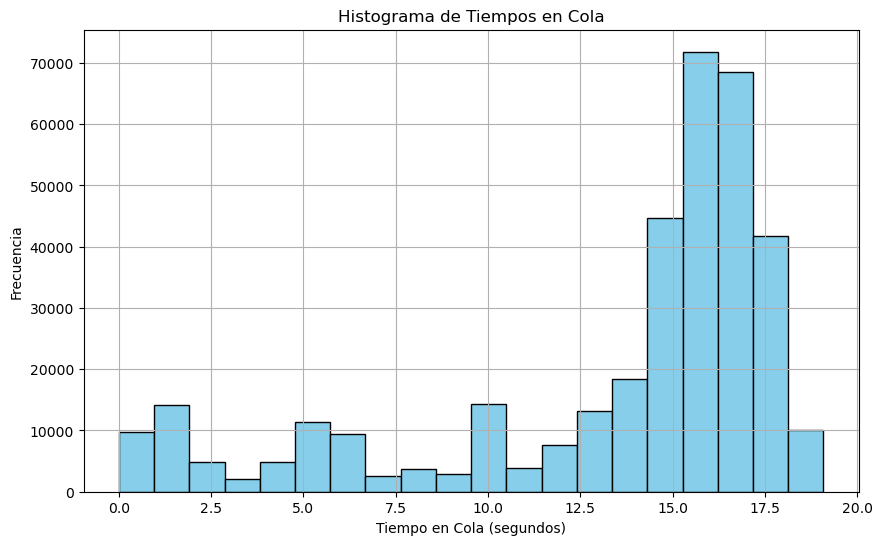


Resultados de Pizzita Computing (6,000 solicitudes por minuto):
a. Solicitudes Totales Atendidas: 359106
b. Tiempo Ocupado Total de Servidores: 35813.04 segundos
c. Tiempo Desocupado Total de Servidores: 186.96 segundos
d. Tiempo Total en Cola: 478538.25 segundos
e. Tiempo Promedio en Cola por Solicitud: 1.3326 segundos
f. Longitud Promedio de Cola por Segundo: 132.9273
g. Tiempo de Salida de la Última Solicitud: 3599.98 segundos


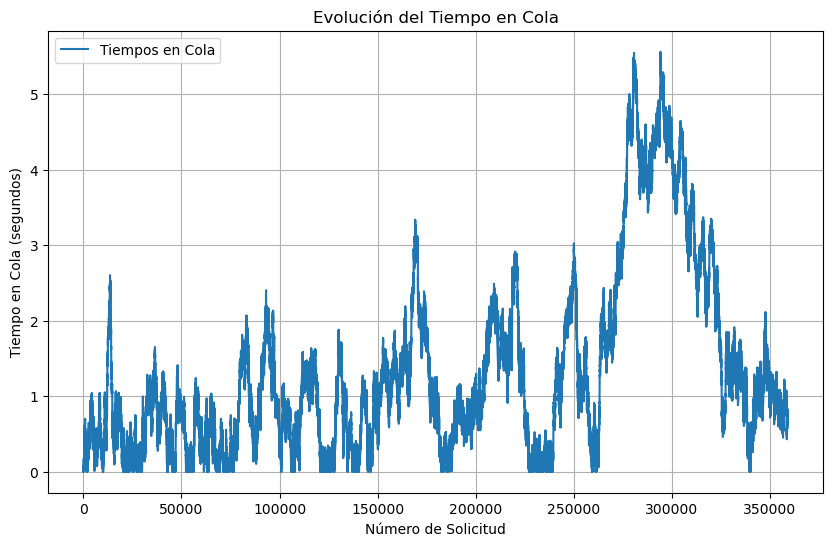

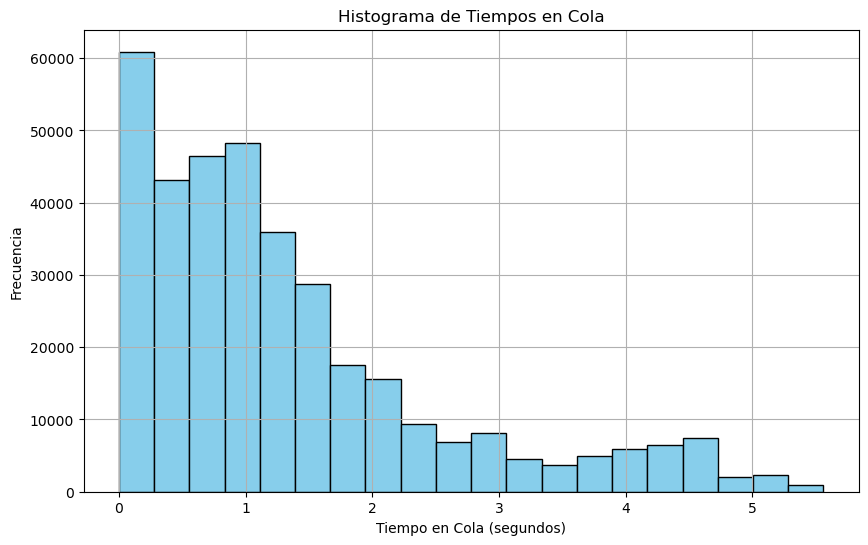


Numero de servidores necesarios para que no haya espera: 27


In [24]:
# Inciso 3: Simulacion con 6,000 solicitudes por minuto
arrival_rate_high = 100
max_requests_per_minute_high = 6000

# Mountain Mega Computing
results_mountain_high = simulate_system(
    system_name='Mountain Mega Computing (6,000 solicitudes por minuto)',
    num_servers=1,
    service_rate=100,
    arrival_rate=arrival_rate_high,
    max_requests_per_minute=max_requests_per_minute_high
)

# Pizzita Computing
results_pizzita_high = simulate_system(
    system_name='Pizzita Computing (6,000 solicitudes por minuto)',
    num_servers=10,  # Usamos el mismo numero inicial de servidores
    service_rate=10,
    arrival_rate=arrival_rate_high,
    max_requests_per_minute=max_requests_per_minute_high
)

print_results(results_mountain_high)
plot_simulation_results(results_mountain_high)
print_results(results_pizzita_high)
plot_simulation_results(results_pizzita_high)

# Determinar el numero de servidores necesarios
required_servers_high = find_required_servers(arrival_rate_high, max_requests_per_minute_high)